# Demo 1: Simulated Data

For this demo I use simulated data to demonstrate the capabilities of the `coorddescent`, `coorddescentCV`, and other supporting functions.

## Package Imports and Initial Setup

In [1]:
import src.coorddescent as cd

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Data Generation and Standardization

I generate a simulated dataset consisting of 500 observations for 10 variables from a normal distribution, with two columns exactly equal to one another (for testing my models' ability to capture collinearity). I generate random coefficients as well such that two of the predictors have no effect on the response (i.e. coefficients = 0), and I assign the same coefficient to the two collinear parameters so their values are exactly identical. The selected coefficients are shown below.

I then generate a response variable based on the random data and predictors, with some noise added to mimic reality.

In [2]:
# generate predictors and coefficients
n, p = 500, 10
np.random.seed(10)
X = np.random.normal(size=(n, p-1))
coeffs = np.random.randint(-p, p, p-1)

# add column of duplicate observations with matching coefficients (for correlation test)
X = np.insert(X, -1, X[:,-1], axis=1)
coeffs = np.append(coeffs, coeffs[-1])

# generate response variable (with noise)
y = np.dot(X, coeffs) + np.random.normal(scale=2, size=n)

print("coefficients = " + str(coeffs))

coefficients = [  9  -1   3   0 -10   0   3   7   4   4]


I split the data into a training set and a test set. The training set will be used to train the models; the test set will be excluded from the training process and therefore will act as "unseen" data for a final evaluation of model performance.

In [3]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

I center and standardize the predictors and the response. Centering allows me to exclude the intercept term from my equations (note: a predicted response of 0 corresponds to the mean of the predictors that were used to train the model).

Standardizing ensures that predictors with different scales do not dominate the minimization process, since the coefficients are included in the penalty terms. Note that I standardize the test set to the same scale as the training set.

In [4]:
# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# scale and center response
y_train_mean = np.mean(y_train)
y_train_sd = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_sd
y_test = (y_test - y_train_mean) / y_train_sd

# save dimensions of training and test sets
n_train, p_train = X_train.shape
n_test, p_test = X_test.shape;

## Ridge Regression with $\lambda$ = 1

I now demonstrate the model fitting process using the `cd.coorddescent` function. I begin with default parameters $\lambda = 1$ and $\alpha = 0$ (corresponding to Ridge regression). I run the model for both `cyclic` and `random` coordinate descent.

In [5]:
lam = 1
alpha = 0  # (Ridge)
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="random", random_seed=0)

The `coorddescent` function returns the values of $\beta$ after every individual step (i.e. after every single minimization of a single coefficient coordinate). The plots below visualize the model fitting process for both the `cyclic` and `random` approaches. The first row shows the entire process for 1000 iterations for both approaches; the plots below zoom in on the action towards the beginning of the fitting process.

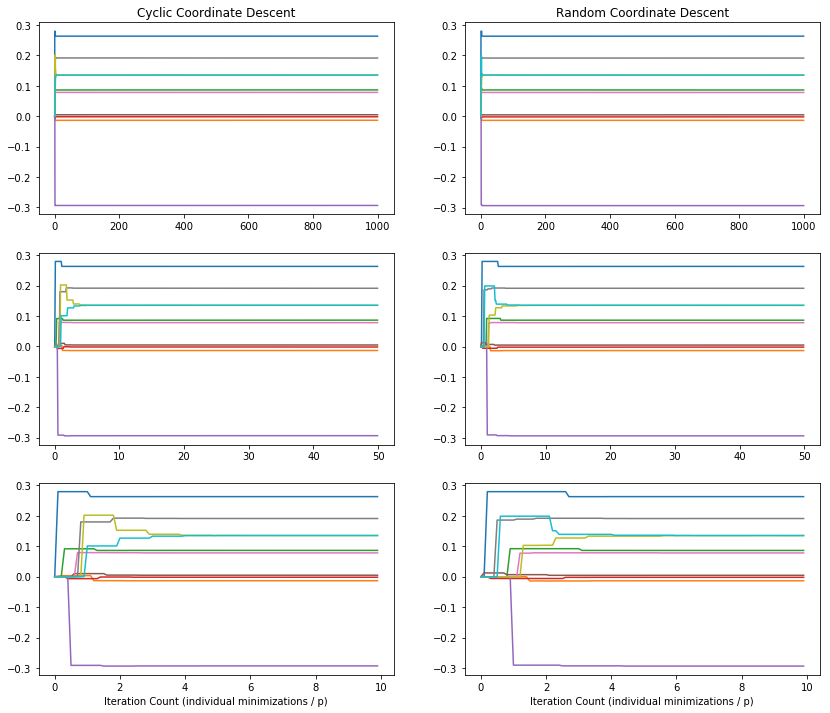

In [6]:
cd.plot_coefficient_steps(betas_cyclic, betas_random, [50, 10])

As shown, both approaches appear to arrive at a stable solution after just 5 iterations or so. Both appear to arrive at similar solutions in the end, though we can see in the third row of plots above that they take different paths to the same end.

My code also includes a function called `compute_obj` which calculates the objective function value for a given $\beta$. I wrap this in a plotting function called `plot_obj_vals_steps` which I use to calculate the objective function value at each individual step and visualize the minimization process.

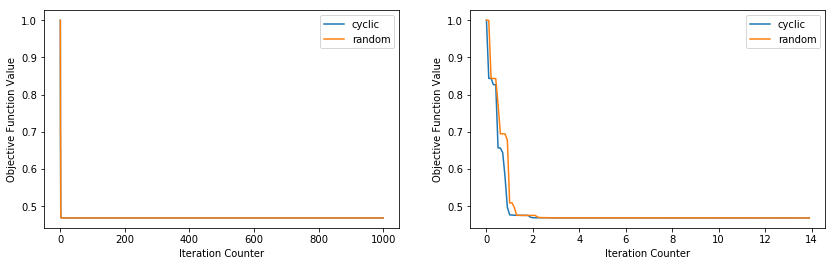

In [7]:
cd.plot_obj_vals_steps(betas_cyclic, betas_random, X_train, y_train, lam, alpha, 14)

As shown, the solutions for both methods approach the minimum after just one or two iterations.

As a reference point, I calculate the mean squared error (MSE) for both approaches as compared to the `y_test` data.

In [8]:
pred_cyclic = X_test.dot(betas_cyclic[-1])
print("cyclic MSE = " + str(mean_squared_error(pred_cyclic, y_test)))

pred_random = X_test.dot(betas_random[-1])
print("random MSE = " + str(mean_squared_error(pred_random, y_test)))

cyclic MSE = 0.207424339218
random MSE = 0.207424339218


It is also worth comparing the coefficient estimates to the known coefficients. I display this comparison graphically below; the scales are different because of the standardization, but the important thing is that the models yield a decent linear correlation to the true coefficients.

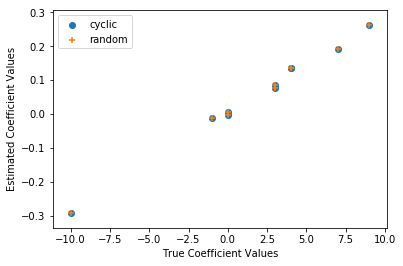

In [9]:
plt.scatter(coeffs, betas_cyclic[-1])
plt.scatter(coeffs, betas_random[-1], marker="+")
plt.xlabel("True Coefficient Values")
plt.ylabel("Estimated Coefficient Values")
plt.legend(["cyclic", "random"]);

## LASSO with $\lambda$ = 1

I now repeat the same process as above, but this time fitting a model with parameters $\lambda = 1$ and $\alpha = 1$ (corresponding to the LASSO). I again run the model for both `cyclic` and `random` coordinate descent.

In [10]:
lam = 1
alpha = 1  # (LASSO)
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, lam, alpha, desc_type="random", random_seed=0)

The `coorddescent` function returns the values of $\beta$ after every individual step (i.e. after every single minimization of a single coefficient coordinate). The plots below visualize the model fitting process for both the `cyclic` and `random` approaches. The first row shows the entire process for 1000 iterations for both approaches; the plots below zoom in on the action towards the beginning of the fitting process.

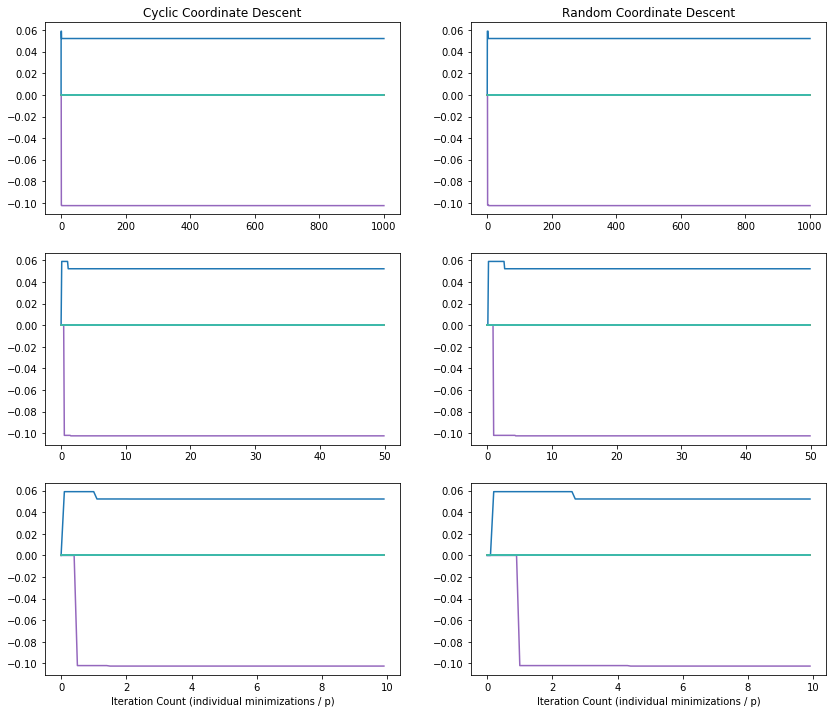

In [11]:
cd.plot_coefficient_steps(betas_cyclic, betas_random, [50, 10])

As shown, both approaches again arrive at stable, roughly equivalent solutions after just 3-4 iterations. In contrast to the previous solution, we see that several coefficients have been reduced to zero, a characteristic trait of the LASSO.

I again use the `compute_obj` function to calculate the objective function value at each individual step and visualize the minimization process.

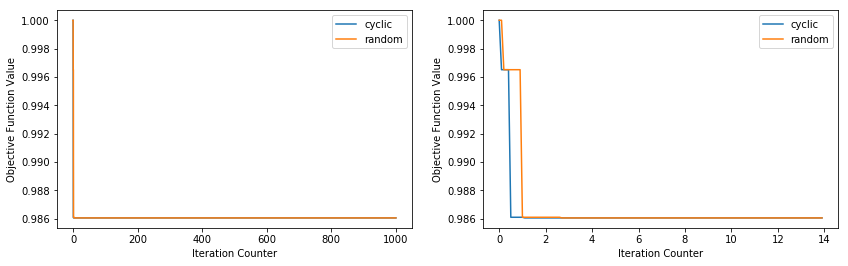

In [12]:
cd.plot_obj_vals_steps(betas_cyclic, betas_random, X_train, y_train, lam, alpha, 14)

As shown, the solutions for both methods approach the minimum after just one or two iterations.

As a reference point, I calculate the mean squared error (MSE) for both approaches as compared to the `y_test` data.

In [13]:
pred_cyclic = X_test.dot(betas_cyclic[-1])
print("cyclic MSE = " + str(mean_squared_error(pred_cyclic, y_test)))

pred_random = X_test.dot(betas_random[-1])
print("random MSE = " + str(mean_squared_error(pred_random, y_test)))

cyclic MSE = 0.781926015466
random MSE = 0.781926015466


The LASSO solution returns much higher MSE than the ridge regression solution above. This should not be a surprise since the former appears to only return two non-zero coefficients, whereas we know that in reality there are only two zero coefficients, while the other 8 are non-zero.

Again, I'll compare the coefficient estimates to the known coefficients. In this case we see an excellent manifestation of the soft-thresholding operator, as coefficients within a certain distance of the origin have been forced to zero.

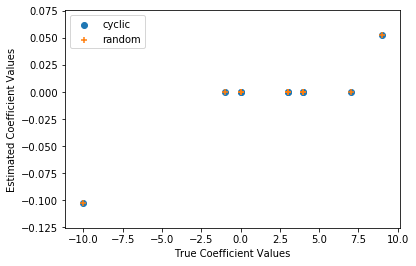

In [14]:
plt.scatter(coeffs, betas_cyclic[-1])
plt.scatter(coeffs, betas_random[-1], marker="+")
plt.xlabel("True Coefficient Values")
plt.ylabel("Estimated Coefficient Values")
plt.legend(["cyclic", "random"]);

## Cross Validation

An important part of fitting any machine learning model is **cross-validation**. Cross-validation helps select appropriate tuning parameters to prevent over- or under-fitting a model to the training data.

Below I define an array of various values of $\lambda$ to try. I then call my `coorddescentCV` function which performs k-folds cross-validation and returns the MSE for each fold and each $\lambda$. I have decided to run 6 folds on just the cyclic coordinate method, and I have gone with an $\alpha$ value of 0.5 as an even compromise between the Ridge and Lasso penalties. I use the `plot_MSEs` function to visualize the results.

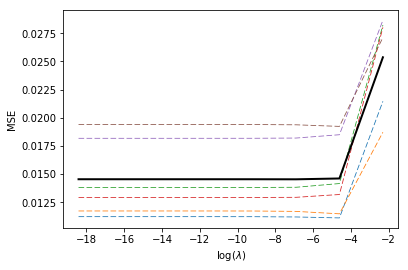

In [15]:
lambdas = np.array([10**k for k in range(-8, 0)])
alpha = 0.5
all_MSEs = cd.coorddescentCV(X_train, y_train, lambdas, alpha, 6, random_seed=30)
cd.plot_MSEs(lambdas, all_MSEs)

In [16]:
lambdas
np.mean(all_MSEs, axis=0)
best_lam = cd.get_best_lambda(lambdas, all_MSEs)
print("best lambda =", best_lam)

array([  1.00000000e-08,   1.00000000e-07,   1.00000000e-06,
         1.00000000e-05,   1.00000000e-04,   1.00000000e-03,
         1.00000000e-02,   1.00000000e-01])

array([ 0.01454661,  0.01454661,  0.0145466 ,  0.01454654,  0.01454587,
        0.01454065,  0.0146131 ,  0.02537464])

best lambda = 0.001


I now use my coordinate descent function to fit models on the Hitters dataset using the optimal $\lambda$ value I found through cross-validation in the previous bullet (i.e. 0.001). I perform this step for both cyclic and random methods.

In [17]:
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="random", random_seed=0)

In [18]:
pred_cyclic = X_test.dot(betas_cyclic[-1])
print("cyclic MSE = " + str(mean_squared_error(pred_cyclic, y_test)))

pred_random = X_test.dot(betas_random[-1])
print("random MSE = " + str(mean_squared_error(pred_random, y_test)))

cyclic MSE = 0.0131299639524
random MSE = 0.0131296119323


Both of the MSEs above are much lower than the MSEs I found in my initial attempts using an arbitrary $\lambda = 1$. This shows the importance of cross-validation! One might consider repeating the process above for different values of $\alpha$ as well.

I plot the predicted response against the actual test response. As we would hope, we see a fairly tight linear relationship. Also note that the predictions are essentially identical for the cyclic and random methods.

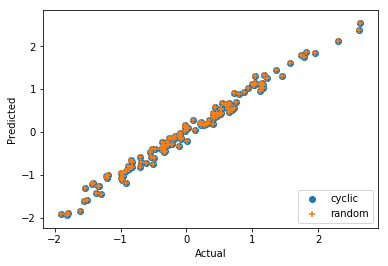

In [19]:
plt.scatter(y_test, X_test.dot(betas_cyclic[-1]));
plt.scatter(y_test, X_test.dot(betas_random[-1]), marker="+")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend(["cyclic", "random"], loc=4);

## Warm Start

"Warm start" refers to the technique used to speed up the process of determining the impact of $\lambda$ on a LASSO solution.

Because of the soft-thresholding operator, the LASSO returns a sparse solution for large $\lambda$ values, with an increasing number of non-zero coefficients as $\lambda$ decreases. One might want to determine the impact of $\lambda$ on the number of non-zero coefficients; however, solving for a dense array of $\lambda$ can be very expensive, especially if _n_ and/or _d_ are very large.

The Warm Start takes advantage of the fact that a LASSO solution for one $\lambda$ value should be very close to the solution for a very similar $\lambda$. Thus, when solving for an array of consecutive $\lambda$ values, the process can be sped up considerably if the solution to the previous problem is used as an initial guess for the subsequent calculation and a norm tolerance is used as a stopping criterion. I display this process below.

I begin by finding the max of the absolute value of the inner products of  $x_j$ and y for all j, divided by n. I multiply by two to account for a factor of the same magnitude in my objective function. This value serves as an upper bound on the size of $\lambda$ to consider since, for any larger $\lambda$ value, the coefficients will all be zero.

In [20]:
2*max(abs(np.inner(X.T, y))/n)

22.732981588399998

Thus, I define a grid of $\lambda$ values starting from ~25 and working my way down towards zero.

In [21]:
# lambdas = np.array([10**k for k in range(-5, 2)])[::-1]
lambdas = np.array([2**(k/5) for k in range(-50, 25)])[::-1]
lambdas[0:20]

array([ 27.85761803,  24.25146506,  21.11212657,  18.37917368,
        16.        ,  13.92880901,  12.12573253,  10.55606329,
         9.18958684,   8.        ,   6.96440451,   6.06286627,
         5.27803164,   4.59479342,   4.        ,   3.48220225,
         3.03143313,   2.63901582,   2.29739671,   2.        ])

I then perform the calculation, using each previous result as the initial guess for my next attempt. I time the process to see how long it takes.

In [22]:
start_time = time.time()

betas_warm_start = np.empty((0,p))
betas = np.zeros(p)
for lam in lambdas:
    betas = cd.coorddescent(betas, X, y, lam, 0.9, tol=0.001)[-1]
    betas_warm_start = np.vstack((betas_warm_start, betas))

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3699309825897217 seconds ---


Only a few seconds -- not bad for fitting several models! Granted, the dataset in this case is not very large. But the process above would come in very handy for larger datasets.

The results are shown graphically below.

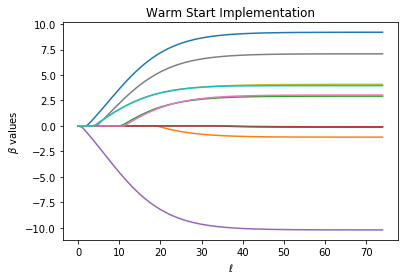

In [23]:
plt.plot(betas_warm_start);
plt.xlabel("$\ell$");
plt.ylabel(r'$\beta$' + " values");
plt.title("Warm Start Implementation");

From the plot above, it looks like all but two coefficients are non-zero from about the 20th to about the 30th $\lambda$ value. Extracting the coefficients at this higher of these two yields the following, shown alongside the true coefficients for reference.

In [24]:
np.vstack((coeffs, betas_warm_start[30])).T

array([[  9.        ,   8.62789621],
       [ -1.        ,  -0.81069359],
       [  3.        ,   2.62375013],
       [  0.        ,   0.        ],
       [-10.        ,  -9.64511446],
       [  0.        ,   0.        ],
       [  3.        ,   2.68470214],
       [  7.        ,   6.57074819],
       [  4.        ,   3.81345136],
       [  4.        ,   3.79904408]])

The coefficients are a close match. Two important observations:

* the model correctly identified the two zero coefficients (for this range of lambdas at least)
* the model yielded approximately equal coefficients to our two collinear variables -- an attribute of the LASSO

Below is a plot of the coefficients against truth, for reference.

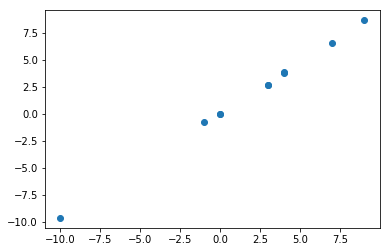

In [25]:
plt.scatter(coeffs, betas_warm_start[30]);